In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import tensorflow as tf
tf.random.set_seed(23)
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Sequential
from keras import Model
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,BatchNormalization,Dropout,Flatten,Input, ReLU
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.backend import clear_session
import gc

In [3]:
df = pd.read_csv('../input/dataset/train.csv')
df

,file,age,gender,race
0,train/1.jpg,50-59,Male,East Asian
1,train/2.jpg,30-39,Female,Indian
2,train/3.jpg,3-9,Female,Black
3,train/4.jpg,20-29,Female,Indian
4,train/5.jpg,20-29,Female,Indian
...,...,...,...,...
86739,train/86740.jpg,20-29,Male,Indian
86740,train/86741.jpg,10-19,Male,Indian
86741,train/86742.jpg,more than 70,Female,Indian
86742,train/86743.jpg,10-19,Female,Black


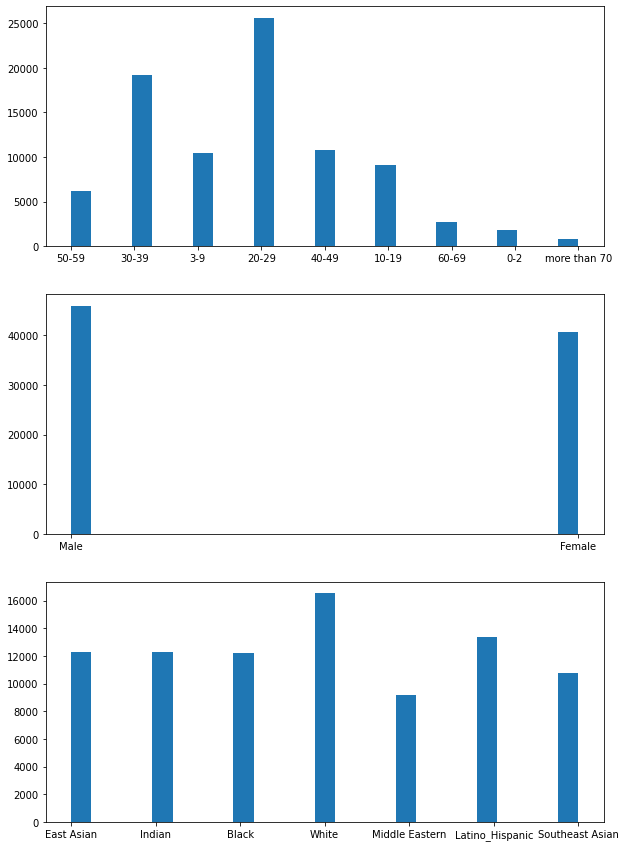

In [4]:
plt.figure(figsize=(10, 15))
bins=25
plt.subplot(3,1,1)
plt.hist(df['age'],bins=bins)

plt.subplot(3,1,2)
plt.hist(df['gender'],bins=bins)

plt.subplot(3,1,3)
plt.hist(df['race'],bins=bins)
plt.show()

# From the above plot, we can see that the age column is imbalanced

In [5]:
df1 = df.sample(frac=1, random_state=73,).reset_index(drop=True)
x1,x2 = df1[:20000], df1[30000:40000]
x1.shape, x2.shape
# Here, i have taken a 20000 sample of the entire dataset

((20000, 4), (10000, 4))

In [6]:
for i in x1.columns[1:]:
    print(x1[i].value_counts())

20-29           5937
30-39           4450
40-49           2473
3-9             2406
10-19           2121
50-59           1400
60-69            651
0-2              388
more than 70     174
Name: age, dtype: int64
Male      10627
Female     9373
Name: gender, dtype: int64
White              3888
Latino_Hispanic    3065
Black              2814
East Asian         2791
Indian             2729
Southeast Asian    2541
Middle Eastern     2172
Name: race, dtype: int64


Enter a number between 0 and 20000:  2345


Text(0.5, 1.0, 'Age range is: 40-49\n race is: Middle Eastern\n Gender is: Male')

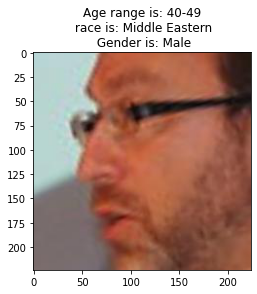

In [7]:
ran = int(input('Enter a number between 0 and {}: '.format(len(x1))))
a=load_img('../input/dataset/'+ x1.file[ran])
plt.imshow(img_to_array(a)/255)
plt.title('Age range is: '+x1['age'][ran]+'\n '+'race is: '+x1['race'][ran] + '\n '+'Gender is: '+x1['gender'][ran])

In [8]:
import PIL
! mkdir ../imgs
! mkdir ../imgs/train
! mkdir ../imgs/test
# Here, i have created separate folders for the train and the test images. I have loaded the images 
# and saved them into this new folder. I have also augmented the train images

In [9]:
datagen = ImageDataGenerator(rotation_range=35, zoom_range=0.2, horizontal_flip=True,
                            brightness_range =(0.2,0.5),height_shift_range=0.2,
                             width_shift_range=0.2)

folder_path = '../input/dataset/'
from tqdm import tqdm
counter = 0
file = []
age = []
gender = []
race = []
def appender(i,j):
    file.append(str(i)+'_'+str(j) + '.jpg')
    age.append(x1.loc[i][1])
    gender.append(x1.loc[i][2])
    race.append(x1.loc[i][3])

    
for i in tqdm(range(len(x1))):
    a=load_img(folder_path+x1.file[i], target_size=(200,200))
    a=img_to_array(a)
    im = PIL.Image.fromarray(a.astype(np.uint8))
    im.save("../imgs/train/" + str(i) + ".jpg")
    # this will save the images into the new folder created
    file.append(str(i)+ '.jpg')
    age.append(x1.loc[i][1])
    gender.append(x1.loc[i][2])
    race.append(x1.loc[i][3])
    counter+=1
    
    val = x1['age'][i] 
    flow = datagen.flow(a.reshape((1,200,200,3)), batch_size=1)
    if val== '40-49' or val== '3-9' or val== '10-19':
        for j in range(1):
            #for all images with ages in the age ranges as above, there will be 1 augmentation
            aug = flow.next()
            im = PIL.Image.fromarray(aug[0].astype(np.uint8))
            im.save("../imgs/train/" + str(i)+ '_'+str(j) + '.jpg')
            appender(i,j)
            counter+=1
            
    elif val== '50-59':
        for j in range(3):
            # for all images with age in range 50-59, there will be 3 augmentaions
            aug = flow.next()
            im = PIL.Image.fromarray(aug[0].astype(np.uint8))
            im.save("../imgs/train/" + str(i)+ '_'+str(j) + '.jpg')
            appender(i,j)
            counter+=1
            
    elif val== '60-69':
        for j in range(7):
            aug = flow.next()
            im = PIL.Image.fromarray(aug[0].astype(np.uint8))
            im.save("../imgs/train/" + str(i)+ '_'+str(j) + '.jpg')
            appender(i,j)
            counter+=1
                       
    elif  val== '0-2':
        for j in range(10):
            aug = flow.next()
            im = PIL.Image.fromarray(aug[0].astype(np.uint8))
            im.save("../imgs/train/" + str(i)+ '_'+str(j) + '.jpg')
            appender(i,j)
            counter+=1
            
    elif val== 'more than 70':
        #for all images with ages more than 70, there will be 20 augmentations
        for j in range(20):
            aug = flow.next()
            im = PIL.Image.fromarray(aug[0].astype(np.uint8))
            im.save("../imgs/train/" + str(i)+ '_'+str(j) + '.jpg')
            appender(i,j)
            counter+=1

if counter == len(file):       
    train_df = pd.DataFrame({'file':file, 'age':age,'gender':gender, 'race':race})
    train_df.to_csv('train.csv', index=False)
    # created a separate dataframe containing image path and other informations
else: print('There might be an error in appending')

100%|██████████| 20000/20000 [07:18<00:00, 45.59it/s]


In [10]:
# Similar process like the train images except that here the test images are not augmented
counter = 0
file = []
age = []
gender = []
race = []
counter = 0

for i in tqdm(range(30000,40000)):
    a=load_img(folder_path+x2.file[i], target_size=(200,200))
    a=img_to_array(a)
    im = PIL.Image.fromarray(a.astype(np.uint8))
    im.save("../imgs/test/" + str(i) + ".jpg")
    file.append(str(i)+ '.jpg')
    age.append(x2.loc[i][1])
    gender.append(x2.loc[i][2])
    race.append(x2.loc[i][3])
    counter+=1

if counter == len(file):       
    test_df = pd.DataFrame({'file':file, 'age':age,'gender':gender, 'race':race})
    test_df.to_csv('test.csv', index=False)
else: print('There might be an error in appending')

100%|██████████| 10000/10000 [01:09<00:00, 144.24it/s]


In [11]:
import shutil
shutil.make_archive("/kaggle/working/imgs", 'zip', "/kaggle/imgs")
# zipping the train and the test images
# Here, i have augmented only the train images

import zipfile

z= zipfile.ZipFile('./imgs.zip')
z.extractall()
#unzipping the files

## Above, i have augmented a sample of images (20000) and saved the images in a newly created folder in the Output

In [22]:
# these dataframes are the newly created dataframes for the sample of the dataset
df_train=pd.read_csv('./train.csv')
df_train=df_train.sample(frac=1,ignore_index=True)

df_test=pd.read_csv('./test.csv')
df_test=df_test.sample(frac=1,ignore_index=True)

df = pd.concat([df_train, df_test])
df_train.shape, df_test.shape, df.shape

((43117, 4), (10000, 4), (53117, 4))

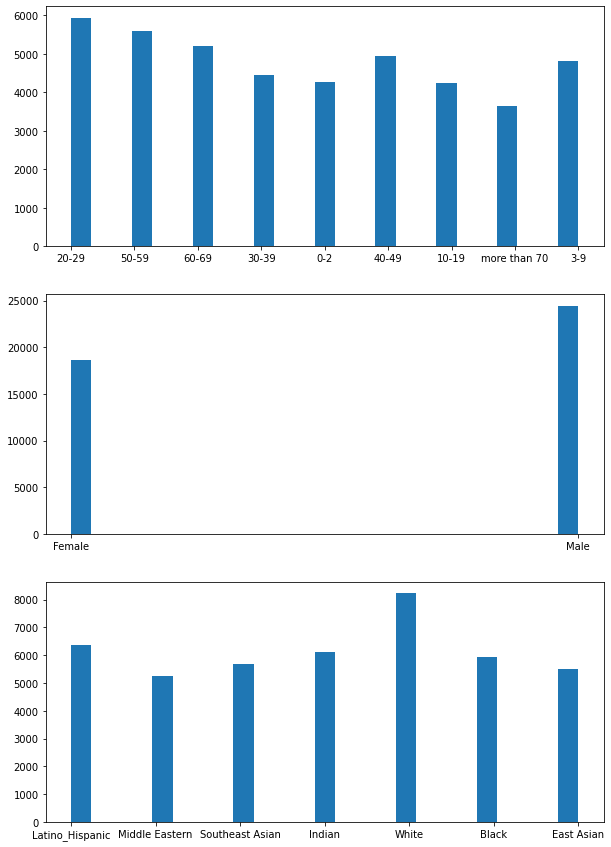

In [23]:
plt.figure(figsize=(10, 15))
bins=25
plt.subplot(3,1,1)
plt.hist(df_train['age'],bins=bins)

plt.subplot(3,1,2)
plt.hist(df_train['gender'],bins=bins)

plt.subplot(3,1,3)
plt.hist(df_train['race'],bins=bins)
plt.show()

# From the above plot, we can see that the age column is no longer imbalanced as before

Enter a number between 0 and 43117:  25367


Text(0.5, 1.0, 'Age range is: 50-59\n race is: Latino_Hispanic\n Gender is: Male')

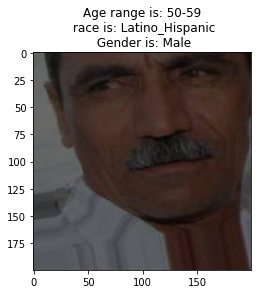

In [16]:
ran = int(input('Enter a number between 0 and {}: '.format(len(df_train))))
a=load_img('./train/'+df_train.file[ran])
plt.imshow(img_to_array(a)/255)
plt.title('Age range is: '+df_train['age'][ran]+'\n '+'race is: '+df_train['race'][ran] + '\n '+'Gender is: '+df_train['gender'][ran])

In [24]:
le_age = LabelEncoder()
le_race = LabelEncoder()
ages = le_age.fit_transform(df['age'])  # label encoding for age
races= le_race.fit_transform(df['race']) # label encoding for race
df=pd.get_dummies(df, columns=['gender'], drop_first=True) # one hot encoding for gender

pair_age={idx:age for idx, age in enumerate(le_age.classes_)}
pair_race={idx:race for idx, race in enumerate(le_race.classes_)}
df['race_enc'] = races
df['age_enc'] = ages



pair_age, pair_race

({0: '0-2',
  1: '10-19',
  2: '20-29',
  3: '3-9',
  4: '30-39',
  5: '40-49',
  6: '50-59',
  7: '60-69',
  8: 'more than 70'},
 {0: 'Black',
  1: 'East Asian',
  2: 'Indian',
  3: 'Latino_Hispanic',
  4: 'Middle Eastern',
  5: 'Southeast Asian',
  6: 'White'})

In [25]:
from tensorflow.keras.applications import InceptionResNetV2
conv_base4 = InceptionResNetV2(include_top=False,weights="imagenet",
                               input_shape=(200,200,3))
# loading the pre trained weights of InceptiionResnetV2 model

In [26]:
input_layer = Input(shape=(200,200,3))
base=conv_base4(input_layer)
conv1 = Conv2D(512, (2,2), (1,1), kernel_initializer=initializers.HeNormal(203),
               bias_initializer = initializers.HeNormal(17))(base)
conv1 = Dropout(0.5)(conv1)
conv1 = BatchNormalization()(conv1)
conv1 = ReLU()(conv1)

conv2 = Conv2D(1024, (2,2), (1,1), kernel_initializer=initializers.HeNormal(903),
              bias_initializer = initializers.HeNormal(67))(conv1)
conv2 = Dropout(0.5)(conv2)
conv2 = BatchNormalization()(conv2)
conv2 = ReLU()(conv2)

flat=Flatten()(conv2)
flat=Dropout(0.5)(flat)

dense = Dense(500, kernel_initializer=initializers.HeNormal(23), bias_initializer = initializers.HeNormal(123))(flat)
dense = Dropout(0.5)(dense)
dense = BatchNormalization()(dense)
dense = ReLU()(dense)

first_dense=Dense(300, kernel_initializer=initializers.HeNormal(273), bias_initializer = initializers.HeNormal(128))(dense)
first_dense=Dropout(0.35)(first_dense)
first_dense=BatchNormalization()(first_dense)
first_dense=ReLU()(first_dense)
y1_output = Dense(1, activation='sigmoid', name='gender')(first_dense)

second_dense = Dense(500, kernel_initializer=initializers.HeNormal(3), bias_initializer = initializers.HeNormal(12))(dense)
second_dense = Dropout(0.5)(second_dense)
second_dense = BatchNormalization()(second_dense)
second_dense + ReLU()(second_dense)
y2_output = Dense(7, activation='softmax', name='race')(second_dense)

third_dense = Dense(500, kernel_initializer=initializers.HeNormal(283), bias_initializer = initializers.HeNormal(103))(dense)
third_dense = Dropout(0.5)(third_dense)
third_dense = BatchNormalization()(third_dense)
third_dense = ReLU()(third_dense)
y3_output = Dense(9, activation='softmax', name='age')(third_dense)

model = Model(inputs=input_layer,outputs=[y1_output, y2_output, y3_output])
conv_base4.trainable = False

optimizer =optimizers.Adam(lr=0.0001)
model.compile(optimizer=optimizer,
            loss={'gender':'binary_crossentropy',
                  'race':'sparse_categorical_crossentropy',
                  'age': 'sparse_categorical_crossentropy'},metrics=['accuracy'],loss_weights=[0.8, 6, 5])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
inception_resnet_v2 (Functional (None, 4, 4, 1536)   54336736    input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_408 (Conv2D)             (None, 3, 3, 512)    3146240     inception_resnet_v2[0][0]        
__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, 3, 3, 512)    0           conv2d_408[0][0]                 
____________________________________________________________________________________________

In [27]:
df_train = df.iloc[:len(df_train),:]
df_test = df.iloc[len(df_train):,:]

epochs=50
batch_size = 32
look_back = 10
steps_per_epochs = len(df_train)// batch_size

train_avg_returns = [] # list of the average values of losses and accuracies over all batches of every epochs(training)
test_avg_returns = []  # list of the average values of losses and accuracies over all batches of every epochs(testing)

for epoch in range(epochs):
    for i in tqdm(range(steps_per_epochs)):
        train_batch_returns =[] #its a list of list of losses, accuracies of every batch in a epoch
        
        idx = np.arange(batch_size*i,batch_size*(i+1))
        batch_img=[]  # it collects the images in a batch
        for ix in idx:
            a= load_img('./train/'+df_train.file[ix]) # loading the images 
            batch_img.append(img_to_array(a)/255.)    # appending the images to form a batch and then pass it to the model to train
        
        #the required labels
        l3 = np.array(df_train['age_enc'][idx])
        l2 = np.array(df_train['race_enc'][idx])
        l1 = np.array(df_train['gender_Male'][idx])
        batch_labels = l1, l2, l3
        train = model.train_on_batch(np.array(batch_img), batch_labels)
        train_batch_returns.append(train) # to
    train_avg_returns.append(np.array(train_batch_returns).mean(axis=0)) #averages the respecitve losses and accuracies over all batches in an epoch
        

    for j in range(len(df_test)// batch_size):
        test_batch_returns = []#its a list of list of losses, accuracies of every batch in a epoch
        
        idx_test = np.arange(batch_size*j,batch_size*(j+1))
        batch_img_test=[] #collect the images in a batch from the test images
        for ix_test in idx_test:
            a= load_img('./test/'+df_test.file[ix_test]) # loading the images
            batch_img_test.append(img_to_array(a)/255.)

        l3_test = np.array(df_test['age_enc'][idx_test])
        l2_test = np.array(df_test['race_enc'][idx_test])
        l1_test = np.array(df_test['gender_Male'][idx_test])
        batch_labels_test = l1_test, l2_test, l3_test
        test = model.test_on_batch(np.array(batch_img_test), batch_labels_test)
        test_batch_returns.append(test)
    test_avg_returns.append(np.array(test_batch_returns).mean(axis=0)) #averages the respecitve losses and accuracies over all batches in an epoch
    print('train_loss: '+str(train_avg_returns[epoch][0]), 'test_loss: '+str(test_avg_returns[epoch][0]))
    print('\n')
    
    if (epoch+1)%2==0:
        model.save('model_{}.h5'.format(epoch+1))
        
    if epoch >look_back:
        if test_avg_returns[epoch][0] > test_avg_returns[epoch-look_back][0]:
            print('Valdation loss did not decrease from the last {} epochs'.format(look_back))
            break
    
    if (epoch + 1)%5 == 0:
        # prints the results after every 5 epochs
        print('Epoch {}/{}\n train_loss: {}\n train_gender_loss: {}\n train_race_loss: {}\n train_age_loss: {}\n\n train_gender_accuracy: {}\n train_race_accuracy: {}\n train_age_accuracy: {}\n\n\n'.format(epoch+1,
               epochs,train_avg_returns[epoch][0], train_avg_returns[epoch][1], train_avg_returns[epoch][2], train_avg_returns[epoch][3], train_avg_returns[epoch][4], train_avg_returns[epoch][5], train_avg_returns[epoch][6]))
        print('Epoch {}/{}\n test_loss: {}\n test_gender_loss: {}\n test_race_loss: {}\n test_age_loss: {}\n\n test_gender_accuracy: {}\n test_race_accuracy: {}\n test_age_accuracy: {}\n\n\n'.format(epoch+1,
               epochs,test_avg_returns[epoch][0], test_avg_returns[epoch][1], test_avg_returns[epoch][2], test_avg_returns[epoch][3], test_avg_returns[epoch][4], test_avg_returns[epoch][5], test_avg_returns[epoch][6]))

100%|██████████| 1347/1347 [04:28<00:00,  5.02it/s]


train_loss: 25.087074279785156 test_loss: 21.16315460205078




100%|██████████| 1347/1347 [04:12<00:00,  5.33it/s]


train_loss: 19.7857666015625 test_loss: 20.22138214111328




100%|██████████| 1347/1347 [04:13<00:00,  5.32it/s]


train_loss: 21.03207778930664 test_loss: 18.631223678588867




100%|██████████| 1347/1347 [04:12<00:00,  5.33it/s]


train_loss: 17.144786834716797 test_loss: 17.892162322998047




100%|██████████| 1347/1347 [04:13<00:00,  5.31it/s]


train_loss: 18.1668643951416 test_loss: 17.558216094970703


Epoch 5/50
 train_loss: 18.1668643951416
 train_gender_loss: 0.6846817135810852
 train_race_loss: 1.7412445545196533
 train_age_loss: 1.4343302249908447

 train_gender_accuracy: 0.46875
 train_race_accuracy: 0.28125
 train_age_accuracy: 0.4375



Epoch 5/50
 test_loss: 17.558216094970703
 test_gender_loss: 0.5337955355644226
 test_race_loss: 1.5944743156433105
 test_age_loss: 1.512866735458374

 test_gender_accuracy: 0.6875
 test_race_accuracy: 0.40625
 test_age_accuracy: 0.34375





100%|██████████| 1347/1347 [04:13<00:00,  5.32it/s]


train_loss: 17.01995086669922 test_loss: 17.54607582092285




100%|██████████| 1347/1347 [04:13<00:00,  5.32it/s]


train_loss: 17.584426879882812 test_loss: 17.32948875427246




100%|██████████| 1347/1347 [04:13<00:00,  5.32it/s]


train_loss: 15.955323219299316 test_loss: 16.9384822845459




100%|██████████| 1347/1347 [04:13<00:00,  5.32it/s]


train_loss: 15.708763122558594 test_loss: 17.13304328918457




100%|██████████| 1347/1347 [04:12<00:00,  5.34it/s]


train_loss: 15.220451354980469 test_loss: 16.708600997924805


Epoch 10/50
 train_loss: 15.220451354980469
 train_gender_loss: 0.513634443283081
 train_race_loss: 1.4032130241394043
 train_age_loss: 1.2780531644821167

 train_gender_accuracy: 0.75
 train_race_accuracy: 0.46875
 train_age_accuracy: 0.40625



Epoch 10/50
 test_loss: 16.708600997924805
 test_gender_loss: 0.3646029829978943
 test_race_loss: 1.5434470176696777
 test_age_loss: 1.4312472343444824

 test_gender_accuracy: 0.875
 test_race_accuracy: 0.4375
 test_age_accuracy: 0.375





100%|██████████| 1347/1347 [04:13<00:00,  5.31it/s]


train_loss: 14.6292724609375 test_loss: 16.526514053344727




100%|██████████| 1347/1347 [04:14<00:00,  5.30it/s]


train_loss: 15.108445167541504 test_loss: 16.235851287841797




100%|██████████| 1347/1347 [04:13<00:00,  5.32it/s]


train_loss: 14.800555229187012 test_loss: 16.347078323364258




100%|██████████| 1347/1347 [04:11<00:00,  5.35it/s]


train_loss: 14.167562484741211 test_loss: 16.384794235229492




100%|██████████| 1347/1347 [04:13<00:00,  5.32it/s]


train_loss: 13.474536895751953 test_loss: 16.409137725830078


Epoch 15/50
 train_loss: 13.474536895751953
 train_gender_loss: 0.49390873312950134
 train_race_loss: 1.207943320274353
 train_age_loss: 1.1663501262664795

 train_gender_accuracy: 0.71875
 train_race_accuracy: 0.59375
 train_age_accuracy: 0.46875



Epoch 15/50
 test_loss: 16.409137725830078
 test_gender_loss: 0.27079343795776367
 test_race_loss: 1.6074872016906738
 test_age_loss: 1.3095159530639648

 test_gender_accuracy: 0.875
 test_race_accuracy: 0.40625
 test_age_accuracy: 0.53125





100%|██████████| 1347/1347 [04:12<00:00,  5.34it/s]


train_loss: 12.839457511901855 test_loss: 16.74317169189453




100%|██████████| 1347/1347 [04:11<00:00,  5.35it/s]


train_loss: 13.240608215332031 test_loss: 16.514278411865234




100%|██████████| 1347/1347 [04:10<00:00,  5.37it/s]


train_loss: 12.182175636291504 test_loss: 17.081472396850586




100%|██████████| 1347/1347 [04:09<00:00,  5.39it/s]


train_loss: 12.918058395385742 test_loss: 17.20988655090332


Valdation loss did not decrease from the last 10 epochs


In [97]:
test_avg_returns

[array([21.1631546 ,  0.65327668,  1.86629915,  1.88854766,  0.5625    ,
         0.1875    ,  0.25      ]),
 array([20.22138214,  0.603818  ,  1.75268602,  1.84444249,  0.6875    ,
         0.34375   ,  0.21875   ]),
 array([18.63122368,  0.57552445,  1.65151358,  1.65234458,  0.71875   ,
         0.375     ,  0.28125   ]),
 array([17.89216232,  0.53679067,  1.64448965,  1.51915812,  0.71875   ,
         0.34375   ,  0.25      ]),
 array([17.55821609,  0.53379554,  1.59447432,  1.51286674,  0.6875    ,
         0.40625   ,  0.34375   ]),
 array([17.54607582,  0.48405141,  1.5722239 ,  1.54509807,  0.75      ,
         0.34375   ,  0.28125   ]),
 array([17.32948875,  0.4912464 ,  1.60817313,  1.45749068,  0.75      ,
         0.34375   ,  0.375     ]),
 array([16.93848228,  0.4404228 ,  1.58662462,  1.41327929,  0.71875   ,
         0.375     ,  0.40625   ]),
 array([17.13304329,  0.40401202,  1.59739745,  1.44508982,  0.8125    ,
         0.40625   ,  0.34375   ]),
 array([16.708601  

In [120]:
m_18 = keras.models.load_model('./model_18.h5')

for j in tqdm(range(len(df_test)// batch_size)):
    test_batch_returns = []#its a list of list of losses, accuracies of every batch in a epoch

    idx_test = np.arange(batch_size*j,batch_size*(j+1))
    batch_img_test=[] #collect the images in a batch from the test images
    for ix_test in idx_test:
        a= load_img('./test/'+df_test.file[ix_test]) # loading the images
        batch_img_test.append(img_to_array(a)/255.)

    l3_test = np.array(df_test['age_enc'][idx_test])
    l2_test = np.array(df_test['race_enc'][idx_test])
    l1_test = np.array(df_test['gender_Male'][idx_test])
    batch_labels_test = l1_test, l2_test, l3_test
    test = m_18.test_on_batch(np.array(batch_img_test), batch_labels_test)
    test_batch_returns.append(test)
    
res = np.array(test_batch_returns).mean(axis=0)
print('Total Test Loss: ', str(res[0]))
print('Test Gender Accuracy: ', str(res[4]))
print('Test Race Accuracy: ', str(res[5]))
print('Test Age Accuracy: ', str(res[6]))

100%|██████████| 312/312 [00:57<00:00,  5.46it/s]

Total Test Loss:  16.290163040161133
Test Gender Accuracy:  0.9375
Test Race Accuracy:  0.46875
Test Age Accuracy:  0.5625


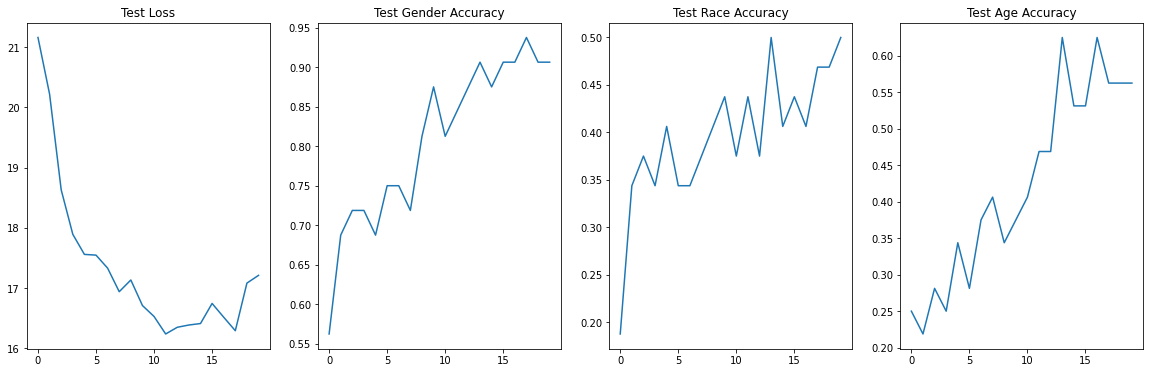

In [118]:
test_total_loss = [i[0] for i in test_avg_returns]
test_gender_acc = [i[4] for i in test_avg_returns]
test_race_acc = [i[5] for i in test_avg_returns]
test_age_acc = [i[6] for i in test_avg_returns]

plt.figure(figsize=(20,6))
plt.subplot(141)
plt.plot(test_total_loss)
plt.title('Test Loss')
plt.subplot(142)
plt.plot(test_gender_acc)
plt.title('Test Gender Accuracy')
plt.subplot(143)
plt.plot(test_race_acc)
plt.title('Test Race Accuracy')
plt.subplot(144)
plt.plot(test_age_acc)
plt.title('Test Age Accuracy')
plt.show()

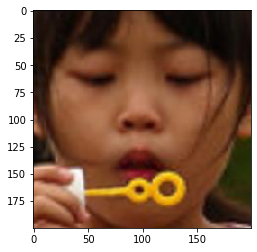

Gender:  Female
Race:  East Asian
Age:  3-9


In [122]:
test_img = load_img('../input/dataset/test/10043.jpg', target_size=(200,200))
test_img = img_to_array(test_img)/255.
res = m1.predict(test_img.reshape((1,200,200,3)))
gender = np.round(res[0])[0][0]
race = np.argmax(res[1])
age = np.argmax(res[2])
plt.imshow(test_img)
plt.show()
print('Gender: ', str(['Female', 'Male'][int(gender)]))
print('Race: ', str(pair_race[race]))
print('Age: ', str(pair_age[age]))

In [ ]:
keras.utils.plot_model(model,to_file='./model_architecture.png', show_shapes=True)